In [1]:
import sys,os
import tarfile
import warnings

import numpy as np
import pandas as pd
import xarray as xr

import SDFC.link as sdl
import NSSEA as ns
import NSSEA.plot as nsp
import NSSEA.models as nsm
import scipy.stats as sc
import statsmodels.api as sm

import cProfile
import pstats
from pstats import SortKey

import matplotlib.backends.backend_pdf as mpdf
import seaborn as sns
import matplotlib.backends.backend_pdf as mpdf
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatch
from matplotlib.ticker import FormatStrFormatter 
import matplotlib.ticker
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

import cftime

import seaborn as sns
import time as tm
import pygam as pg

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#Stan necessities
#import nest_asyncio
#import stan
#nest_asyncio.apply()


#cmd Pystan utilities
from cmdstanpy import CmdStanModel
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True #No long log

#Stan Functions
from cmdstanpy import cmdstan_path, set_cmdstan_path

set_cmdstan_path('/home/barbauxo/miniconda3/envs/TestSDFC/bin/cmdstan') #To adapt
cmdstan_path()

Number of processors:  8


'/home/barbauxo/miniconda3/envs/TestSDFC/bin/cmdstan'

In [2]:
# dd/mm/YY H:M:S
import random
dt_string = "10091028"
print( dt_string)
random.seed(int(dt_string))

10091028


# Data

In [3]:
basepath=os.path.abspath(os.getcwd())
pathOut=os.path.join(basepath,'./Output/',dt_string)
if not os.path.exists(pathOut):
    os.makedirs(pathOut)

pathGCM=os.path.join(basepath,'./Data/GCM/')
pathObs=os.path.join(basepath,'./Data/Observations/')

time_period    = np.arange( 1850 , 2101 , 1 , dtype = int )


In [4]:
#Load Files

## Load Observations
dXo = xr.open_dataset(os.path.join( pathObs,"Xo.nc")) #Deja en anomalies
Xo  = pd.DataFrame( dXo.tas.values.squeeze() , columns = ["Xo"] , index = dXo.time["time.year"].values )

dYo = xr.open_dataset(os.path.join(pathObs,"Yo.nc"))
Yo  = pd.DataFrame( dYo.TX.values.squeeze() , columns = ["Yo"] , index = dYo.time["time.year"].values )

#LOad GCM

################ Liste Modele+type+scenario
## List of models X
pathInpX= os.path.join(pathGCM,"tas")
modelsX = [  "_".join(f.split("/")[-1][:-3].split("_")[:3]) for f in os.listdir(pathInpX) ] #Modele+type+scenario
modelsX.sort()


## List of models Y
pathInpY= os.path.join(pathGCM,"tasmax")
modelsY =  [  "_".join(f.split("/")[-1][:-3].split("_")[:3]) for f in os.listdir(pathInpY) ] #Modele+type+scenario
modelsY.sort()
models = list(set(modelsX) & set(modelsY)) #Conserve si meme Modele+type+scenario pour tas et tasmax
models.sort()
## Load X and Y
lX = []
lY = []
for m in models:
        model, typeRun, scen=m.split("_")

        ## Load X
        
        df   = xr.open_dataset( os.path.join( pathInpX , "{}_tas_YearMean_Europe.nc".format(m) )  ,decode_times=False )
        time = df.time.values.astype(int)
        X    = pd.DataFrame( df.tas.values.ravel() , columns = [m] , index = time ) 
        X=pd.DataFrame( np.array(X.values.ravel()), 
          columns = [str(m)] , index = time )
        X[str(m)]=X[str(m)].astype(float)
        lX.append(  X)
    
        ## Load Y
        df   = xr.open_dataset( os.path.join( pathInpY , "{}_tasmax_YearMax_Tricastin.nc".format(m) ) ,decode_times=False  )
        time = df.time.values.astype(int)
        Y    = pd.DataFrame( df.tasmax.values.ravel() , columns = [m] , index = time )
        Y=pd.DataFrame( np.array(Y.values.ravel()), 
          columns = [str(m)] , index = time )
        Y[str(m)]=Y[str(m)].astype(float)
        lY.append( Y)
        


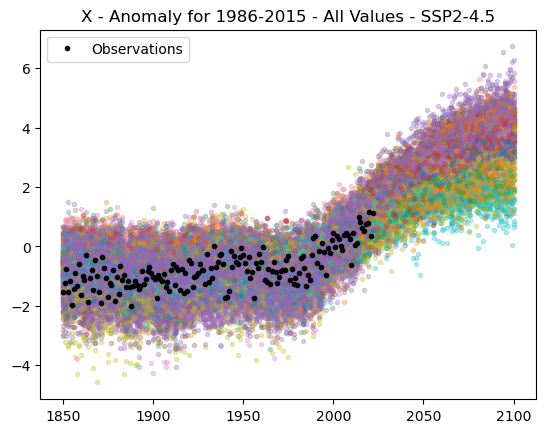

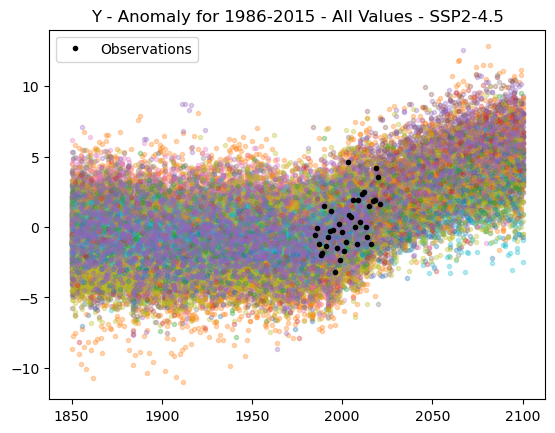

In [5]:

    scen="SSP2-4.5"
    fig, ax = plt.subplots()
    period=list(time_period)
    for i in range(len(models)):
        X=lX[i]
        period2=X.index
        ax.plot(period2,X.values.ravel(),linestyle = ""  , marker=  "." ,alpha=0.3 )
    ax.plot( Xo.index , Xo.values        , color = "black" , linestyle = ""  , marker=  "." , label="Observations")
    xlim = ax.get_xlim()    
    ax.set_xlim(xlim)
    plt.title("X - Anomaly for 1986-2015 - All Values - "+scen)
    plt.legend( )    
    plt.savefig(os.path.join( pathOut ,"AnnexeFigure1A.png"))
    plt.show()
    
    
    fig, ax = plt.subplots()
    for i in range(len(models)):
        Y=lY[i]
        period2=Y.index
        ax.plot(period2,Y.values.ravel() ,linestyle = ""  , marker=  "." ,alpha=0.3 )
    ax.plot( Yo.index , Yo.values.ravel(), color = "black" , linestyle = ""  , marker=  "." , label="Observations")
    xlim = ax.get_xlim()    
    ax.set_xlim(xlim)
    plt.title("Y - Anomaly for 1986-2015 - All Values - "+scen)
    plt.legend( )    
    plt.savefig(os.path.join( pathOut ,"AnnexeFigure1B.png"))
    plt.show()

# Calculations

In [6]:
#Parameters

time_reference = np.arange( 1986 , 2016 , 1 , dtype = int )

ci          = 0.05
sample_dis=False #If want n sample of each GCM model. For graph only, not used for multisynthesis. Takes a lot of time


deb=1850
fin=2101

ns_law      = nsm.GEV()
event       = ns.Event( "HW19" , 2019 , time_reference , type_ = "value" , variable = "TX3X" , unit = "K" )
n_sample    = 100
verbose=False
event.value = float(Yo.loc[event.time])
bias_multi=36.47666667 #Still manual value (mean from absolute observation data over the reference period)

In [7]:
## Prior Functions (Light_version is faster but less precise)
##================================
light=True
t0 = tm.time()
t_Origin = tm.time()
clim = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim.time , n_sample + 1 , fix_first = 0 )
clim =ns.covariates_FC_GAM( clim , lX ,  Xebm , dof = 7 , verbose = False,light=light )
clim = ns.nslaw_fit( lY , clim , verbose = verbose,light= light ) 

clim= ns.infer_multi_model( clim , verbose = verbose )

clim.to_netcdf( os.path.join( pathOut , ("clim_"+dt_string+".nc")  ) )
## Add constraint on X
clim_MM = clim.copy()
clim_MM.keep_models( "Multi_Synthesis" )
clim_CX    = ns.constrain_covariate( clim_MM , Xo , time_reference , verbose = verbose )
t1 = tm.time()
total = t1-t0
print(total)

clim_CX.to_netcdf( os.path.join( pathOut , ("clim_CX_"+dt_string+".nc")  ) )

43.31967520713806


In [8]:
# Version STAN
def stan_constrain(climIn,Yo, **kwargs):
    clim      = climIn.copy()
    #data
    X=clim.X.loc[Yo.index,'BE',"F","Multi_Synthesis"].values.squeeze()
    N_X=len(X)
    Y=Yo.values.squeeze()
    N=len(Y)
    p_m   = clim.data["mm_mean"][-clim.n_coef:].values
    p_cov    = clim.data["mm_cov"][-clim.n_coef:,-clim.n_coef:].values

    u,s,v = np.linalg.svd(p_cov)
    p_std = u @ np.sqrt(np.diag(s)) @ v.T
    
    #clim para
    n_features = clim.ns_law.n_ns_params
    ns_params_names = clim.ns_law.get_params_names()
    n_ess = kwargs.get("n_ess")
    if n_ess is None:
        n_ess = 10
    sample_names =[s+"_"+str(i) for i in range(n_ess) for s in clim.sample[1:]]+["BE"]
    law_coef_bay   = xr.DataArray( np.zeros( (n_features,(clim.n_sample)*n_ess + 1,1) ) ,
                                  coords = [ ns_params_names , sample_names , ["Multi_Synthesis"] ] ,
                                  dims = ["coef","sample_MCMC","model"] )
    
    
    
    newDF = pd.DataFrame() #creates a new dataframe that's empty
    samples=clim.X.loc[Yo.index,:,"F","Multi_Synthesis"].sample.values.squeeze()[1::]

    #compile stan file
    stan_file = 'GEV_non_stationary.stan'
    model = CmdStanModel(stan_file=stan_file)

    for s in samples:
        print(s)
        X=clim.X.loc[Yo.index,s,"F","Multi_Synthesis"].values.squeeze()
        data = {"N":N,
                "Y": Y,
                "N_X": N_X,
                "X": X,
                "p_m":p_m,
                "p_cov":p_std
                }
    
        fit = model.sample(data=data,iter_sampling=int(n_ess/4),show_progress=False)
        df = fit.draws_pd()
        sub_def=df[['para[1]','para[2]','para[3]','para[4]','para[5]']]
        law_coef_bay.loc[:,[s+"_"+str(i) for i in range(n_ess)],"Multi_Synthesis"]=sub_def.T
    clim.law_coef=law_coef_bay
    clim.law_coef.loc[:,"BE",:] = clim.law_coef[:,1:,:].median( dim = "sample_MCMC" )
    clim.BE_is_median = True
    return clim


In [9]:
bayes_kwargs = { "n_ess"   : 100   }
t0 = tm.time()
climCXCB_stan=stan_constrain(clim_CX,Yo, **bayes_kwargs)
t1 = tm.time()
total = t1-t0
print(total)
climCXCB_stan.to_netcdf( os.path.join( pathOut , ("clim_CXCB_"+dt_string+".nc")  ) )

S000
S001
S002
S003
S004
S005
S006
S007
S008
S009
S010
S011
S012
S013
S014
S015
S016
S017
S018
S019
S020
S021
S022
S023
S024
S025
S026
S027
S028
S029
S030
S031
S032
S033
S034
S035
S036
S037
S038
S039
S040
S041
S042
S043
S044
S045
S046
S047
S048
S049
S050
S051
S052
S053
S054
S055
S056
S057
S058
S059
S060
S061
S062
S063
S064
S065
S066
S067
S068
S069
S070
S071
S072
S073
S074
S075
S076
S077
S078
S079
S080
S081
S082
S083
S084
S085
S086
S087
S088
S089
S090
S091
S092
S093
S094
S095
S096
S097
S098
S099
38.7843918800354


In [10]:
params_CXCB=ns.build_params_along_time_ess( climCXCB_stan, verbose = verbose )

# Results - Figure 4 

In [11]:
#Time period of interest
T=1000
T1=2050
T2=2100

In [12]:
## Effective return level for each year

In [13]:
def RL_IC(params,T,m="Multi_Synthesis"):
    sample_para=params.sample[params.sample!='BE'].values

    RL_coef_bay   = xr.DataArray( np.zeros( (len(sample_para),len(time_period) ) ),
                                  coords = [ sample_para ,time_period  ] ,
                                  dims = ["sample","period"] )
    for i in range(len(sample_para)):
                             s=sample_para[i]
                             loc=params.loc[time_period,s,'F','loc' ,m].values.squeeze()
                             scale=params.loc[time_period,s,'F','scale'  ,m].values.squeeze()
                             shape=params.loc[time_period,s,'F','shape' ,m].values.squeeze()
                             RL_coef_bay.loc[sample_para[i],:]=sc.genextreme.ppf((1-1/T), -shape, loc,scale) 
    return RL_coef_bay

In [14]:
if not os.path.exists(os.path.join( pathOut, ("saved_RL_posterior_"+str(T)+"ans_"+dt_string+".nc") )):
    
    Q_1000_posterior=RL_IC(params_CXCB,T) 
    Q_1000_posterior.to_netcdf(os.path.join( pathOut, ("saved_RL_posterior_"+str(T)+"ans_"+dt_string+".nc") ))
    print(T)
Q_1000_posterior=xr.open_dataarray(os.path.join(pathOut, ("saved_RL_posterior_"+str(T)+"ans_"+dt_string+".nc") ))
Q_1000_posterior_quantiles=Q_1000_posterior.quantile( [ ci / 2 , 1 - ci / 2 , 0.5 ] , dim = "sample" ).assign_coords( quantile = ["ql","qu","BE"] )


Tmed=2
if not os.path.exists(os.path.join( pathOut, ("saved_RL_posterior_"+str(Tmed)+"ans_"+dt_string+".nc") )):
    
    Q_2_posterior=RL_IC(params_CXCB,Tmed) 
    Q_2_posterior.to_netcdf(os.path.join( pathOut, ("saved_RL_posterior_"+str(Tmed)+"ans_"+dt_string+".nc") ))
    print(Tmed)
Q_2_posterior=xr.open_dataarray(os.path.join( pathOut,("saved_RL_posterior_"+str(Tmed)+"ans_"+dt_string+".nc") ))
Q_2_posterior_quantiles=Q_2_posterior.quantile( [ ci / 2 , 1 - ci / 2 , 0.5 ] , dim = "sample" ).assign_coords( quantile = ["ql","qu","BE"] )


## Predictive Equivalent Return Level

In [15]:
#Predictive: Méthode par max

def max_predictive_dist_theta(s,params,T1,T2,size=1000,m='Multi_Synthesis'):
    loc=params.loc[range(T1,T2+1),s,'F','loc' ,m].values.squeeze()
    scale=params.loc[range(T1,T2+1),s,'F','scale'  ,m].values.squeeze()
    shape=params.loc[range(T1,T2+1),s,'F','shape' ,m].values.squeeze()
    pred_dist_s=[max(sc.genextreme.rvs( c=-shape,loc=loc,
                            scale=scale)) for j in range(size)]
    return(pred_dist_s)
def pred_proba_max(params,T1,T2,size=1000):
    sample_para=params.sample[:-1].values

    law_coef_bay   = xr.DataArray( np.zeros( (len(sample_para),size) ) ,
                                  coords = [ sample_para ,range(size)  ] ,
                                  dims = ["coef","Max_EQR"] )
    for i in range(len(sample_para)):
        law_coef_bay.loc[sample_para[i],:]=max_predictive_dist_theta(sample_para[i],params,T1,T2,size=size) 
    return(law_coef_bay)

In [16]:
#Long the first time
Eq_Reliability_T=(1-1/T)**(T2-T1+1)
if not os.path.exists(os.path.join( pathOut , ("saved_tirages_pred_EQR_posterior_"+str(T1)+"_"+str(T2)+"_"+dt_string+".nc") )):
    print("Tirage predictive EQR")
    law_coef_bay_posterior=pred_proba_max(params_CXCB,T1,T2,size=1000)
    law_coef_bay_posterior.to_netcdf(os.path.join( pathOut , ("saved_tirages_pred_EQR_posterior_"+str(T1)+"_"+str(T2)+"_"+dt_string+".nc") ))

law_coef_bay=xr.open_dataarray(os.path.join( pathOut , ("saved_tirages_pred_EQR_posterior_"+str(T1)+"_"+str(T2)+"_"+dt_string+".nc") ))
predict_EQR=float(law_coef_bay.quantile(Eq_Reliability_T))+bias_multi

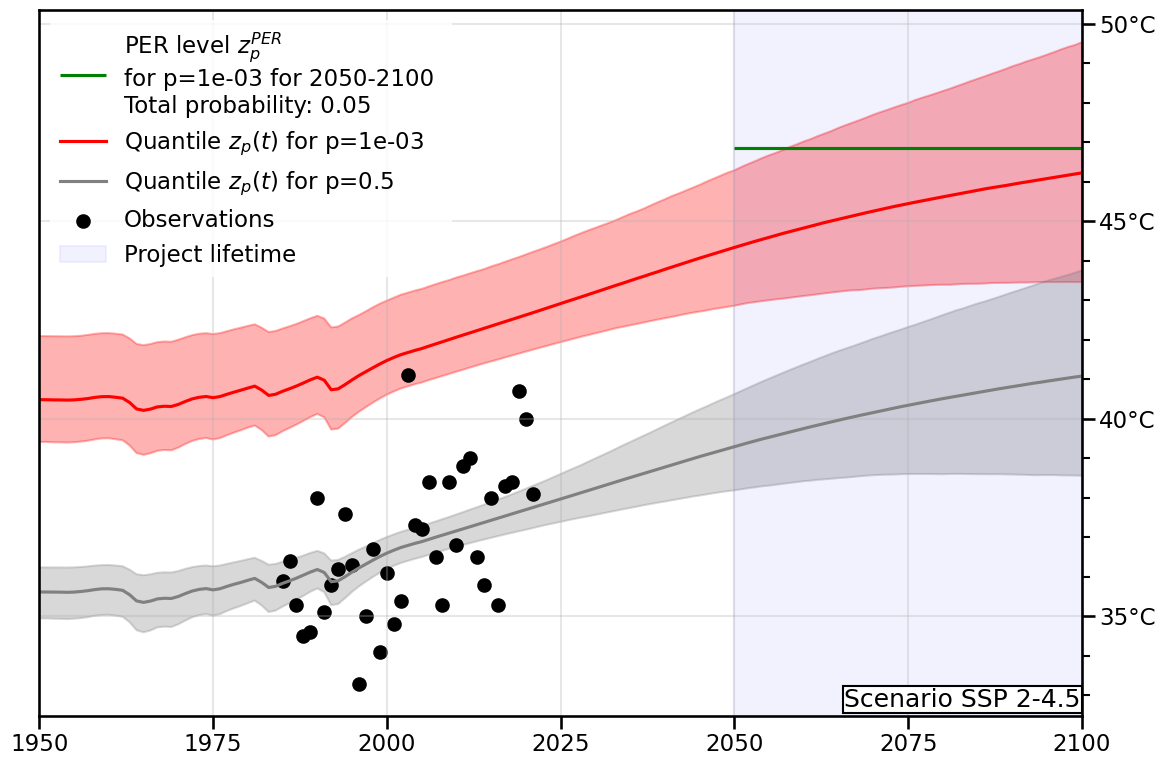

In [17]:

ofile=os.path.join(  pathOut+"Figure4.pdf" )
pdf= mpdf.PdfPages( ofile )
fig = plt.figure( figsize = (12,8) )
sns.set_context("talk")

p=1/T

label = ["Project lifetime",
         "Quantile $z_p(t)$ for p="+"{:.0e}".format(p),
         "Quantile $z_p(t)$ for p=0.5",
         "Observations",
         "PER level $z_p^{PER}$ \nfor p="+"{:.0e}".format(p)+" for 2050-2100 \nTotal probability: "+str(round(1-Eq_Reliability_T,2))  ]



ax = fig.add_subplot( 1 , 1 ,  1 )
plt.hlines(y=predict_EQR,
           xmin=T1, xmax=np.max(time_period),
           color='g',
           linestyle='-',
           label=label[4])
ax.plot( time_period ,
        Q_1000_posterior_quantiles.loc["BE",time_period] +bias_multi,
        color = "red" ,
        label=label[1])
ax.fill_between( time_period , 
                Q_1000_posterior_quantiles.loc["ql",time_period] +bias_multi,
                Q_1000_posterior_quantiles.loc["qu",time_period]+bias_multi ,
                color = "red" ,
                alpha = 0.3 )


ax.plot( time_period ,
        Q_2_posterior_quantiles.loc["BE",time_period] +bias_multi,
        color = "grey" ,
        label=label[2])
ax.fill_between( time_period ,
                Q_2_posterior_quantiles.loc["ql",time_period] +bias_multi,
                Q_2_posterior_quantiles.loc["qu",time_period]+bias_multi ,
                color = "grey" ,
                alpha = 0.3 )

ax.scatter( Yo.index, Yo+bias_multi,
           color = "black" ,
           label=label[3])





ax.axvspan(T1, T2,
           alpha=0.05,
           color='blue',
           label=label[0])

ax.text(2100-0.2, plt.ylim()[0]+0.1, 'Scenario SSP 2-4.5', color='black', ha="right", va="bottom",
        bbox=dict(facecolor='white', edgecolor='black',pad=1))


#label = ["Time period","RL 1000y", "RL 2y", "Obs", "EQR"]
legend = [mplpatch.Patch(facecolor = c , edgecolor = c , label = l , alpha = 0.5 ) for c,l in zip(["blue","red","grey","black","green"],label)]

fig.set_tight_layout(True)
ax.set(xlim=(1950,np.max(time_period)))
ax.xaxis.set_major_locator(MultipleLocator(25))


plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d°C'))
ax.yaxis.tick_right()
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.grid(alpha=0.3)

#ax.legend( frameon=False, )#handles = legend ,loc='upper left')
leg=ax.legend( )
leg.get_frame().set_edgecolor('white')

plt.show()
pdf.savefig(fig, bbox_inches = 'tight')
plt.close(fig)
pdf.close()

# Annexes Figures

### Credibility intervals for the ER Level

In [18]:
#Functions

def proba_period_mult(x,para_s,T1,T2,xlen):
    proba_full=np.zeros(shape=( T2+1-T1,xlen))
    for i in range(T1,T2+1):
        proba_full[i-T1]=np.asarray([sc.genextreme.cdf(x, -para_s.loc[i,'shape'].values,para_s.loc[i,'loc'].values,para_s.loc[i,'scale'].values) ])
    proba_z=np.prod(proba_full,axis=0)   
    return proba_z




def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
#For EQR functions
def Find_EQR(para_s,T,T1,T2,xlen=1000,m='Multi_Synthesis'):
    min_val_s=sc.genextreme.ppf((1-1/T), -para_s.loc[T1,'shape'].values,para_s.loc[T1,'loc'].values,para_s.loc[T1,'scale'].values) 
    max_val_s=sc.genextreme.ppf((1-1/T), -para_s.loc[T2,'shape'].values,para_s.loc[T2,'loc'].values,para_s.loc[T2,'scale'].values)
    x = np.linspace(max_val_s,min_val_s ,xlen) #Valeurs a tester
    test_val_s=proba_period_mult(x,para_s,T1,T2,xlen)  #Probabilité sur la periode t1 t2 pour chaque valeur
    Eq_Reliability=(1-1/T)**(T2-T1+1) #Formule EQR
    idx=find_nearest(test_val_s, Eq_Reliability) # Valeur dont la proba est la plus prche de lEQR
    
 
    return x[idx],test_val_s[idx],Eq_Reliability
def Find_EQR_IC(m,params,T,T1,T2,ci,xlen=1000):
    para_s=params.loc[:,'BE','F',:,m] #BE
    #params[:,1:,:,:,:].loc[:,:,'F',:,m][:,s,:] #qUANTILE
    EQR_Be, P_BE,EQR=Find_EQR(para_s,T,T1,T2,xlen)
    #EQR_S=proba_full=np.zeros(shape=( len(params.sample)-1,1))
    #EQR_P=proba_full=np.zeros(shape=( len(params.sample)-1,1))
    EQR_S=np.zeros( len(params.sample)-1)
    
    EQR_P=np.zeros( len(params.sample)-1)
    for i in range(0,len(params.sample)-1):
        print(i/len(params.sample))
        para_s= params[:,1:,:,:,:].loc[:,:,'F',:,m][:,i,:] #qUANTILE
        a=Find_EQR(para_s,T,T1,T2,xlen)
        
        EQR_S[i], EQR_P[i],EQR=a
    return np.quantile(EQR_S,ci / 2),np.median(EQR_S),EQR_Be ,P_BE,EQR,np.quantile(EQR_S,1-ci / 2),EQR_S,EQR_P

In [19]:
m='Multi_Synthesis'
Ql_EQR,Qm_EQR,EQR_BE ,P_BE,EQR,Qu_EQR,EQR_S,EQR_P=Find_EQR_IC(m,params_CXCB,T,T1,T2,ci)
#abs T
Ql_EQR_abs,Qm_EQR_abs,Qu_EQR_abs=Ql_EQR+bias_multi,Qm_EQR+bias_multi,Qu_EQR+bias_multi
time_study = np.arange( T1 , T2+1 , 1 , dtype = int )
Ql_vect=[Ql_EQR_abs]*len(time_study)
Qu_vect=[Qu_EQR_abs]*len(time_study)


0.0
9.999000099990002e-05
0.00019998000199980003
0.00029997000299970003
0.00039996000399960006
0.0004999500049995
0.0005999400059994001
0.0006999300069993001
0.0007999200079992001
0.0008999100089991
0.000999900009999
0.0010998900109989002
0.0011998800119988001
0.0012998700129987
0.0013998600139986002
0.0014998500149985001
0.0015998400159984002
0.0016998300169983002
0.0017998200179982
0.0018998100189981002
0.001999800019998
0.0020997900209979003
0.0021997800219978004
0.0022997700229977
0.0023997600239976003
0.0024997500249975004
0.0025997400259974
0.0026997300269973002
0.0027997200279972004
0.0028997100289971
0.0029997000299970002
0.0030996900309969004
0.0031996800319968005
0.0032996700329967
0.0033996600339966003
0.0034996500349965005
0.0035996400359964
0.0036996300369963003
0.0037996200379962005
0.0038996100389961006
0.003999600039996
0.0040995900409959
0.004199580041995801
0.004299570042995701
0.004399560043995601
0.0044995500449955
0.0045995400459954
0.0046995300469953
0.00479952004

0.0403959604039596
0.040495950404959506
0.0405959404059594
0.040695930406959305
0.04079592040795921
0.0408959104089591
0.040995900409959006
0.0410958904109589
0.041195880411958805
0.04129587041295871
0.0413958604139586
0.041495850414958506
0.0415958404159584
0.041695830416958304
0.04179582041795821
0.0418958104189581
0.041995800419958006
0.0420957904209579
0.042195780421957804
0.04229577042295771
0.0423957604239576
0.042495750424957505
0.0425957404259574
0.042695730426957304
0.04279572042795721
0.0428957104289571
0.042995700429957005
0.0430956904309569
0.043195680431956804
0.04329567043295671
0.0433956604339566
0.043495650434956505
0.0435956404359564
0.043695630436956304
0.043795620437956206
0.0438956104389561
0.043995600439956005
0.04409559044095591
0.044195580441955803
0.044295570442955706
0.0443955604439556
0.044495550444955505
0.04459554044595541
0.0446955304469553
0.044795520447955206
0.0448955104489551
0.044995500449955005
0.04509549045095491
0.0451954804519548
0.0452954704529547

0.0817918208179182
0.08189181081891811
0.08199180081991801
0.08209179082091791
0.0821917808219178
0.0822917708229177
0.08239176082391761
0.08249175082491751
0.08259174082591741
0.0826917308269173
0.0827917208279172
0.08289171082891711
0.08299170082991701
0.08309169083091691
0.0831916808319168
0.0832916708329167
0.08339166083391661
0.08349165083491651
0.08359164083591641
0.0836916308369163
0.0837916208379162
0.08389161083891611
0.08399160083991601
0.08409159084091591
0.0841915808419158
0.0842915708429157
0.08439156084391561
0.08449155084491551
0.08459154084591541
0.0846915308469153
0.0847915208479152
0.08489151084891511
0.08499150084991501
0.08509149085091491
0.0851914808519148
0.0852914708529147
0.08539146085391461
0.08549145085491451
0.08559144085591441
0.0856914308569143
0.0857914208579142
0.08589141085891411
0.08599140085991401
0.08609139086091391
0.0861913808619138
0.0862913708629137
0.08639136086391361
0.08649135086491351
0.08659134086591341
0.0866913308669133
0.0867913208679132
0

0.12358764123587641
0.12368763123687632
0.12378762123787622
0.12388761123887611
0.12398760123987601
0.12408759124087591
0.12418758124187582
0.12428757124287572
0.12438756124387561
0.12448755124487551
0.12458754124587541
0.12468753124687532
0.12478752124787522
0.12488751124887511
0.12498750124987501
0.1250874912508749
0.12518748125187482
0.1252874712528747
0.12538746125387462
0.1254874512548745
0.1255874412558744
0.12568743125687432
0.1257874212578742
0.12588741125887412
0.125987401259874
0.1260873912608739
0.12618738126187382
0.1262873712628737
0.12638736126387362
0.1264873512648735
0.12658734126587343
0.12668733126687332
0.1267873212678732
0.12688731126887312
0.126987301269873
0.12708729127087293
0.12718728127187282
0.1272872712728727
0.12738726127387262
0.1274872512748725
0.12758724127587243
0.12768723127687232
0.1277872212778722
0.12788721127887212
0.127987201279872
0.12808719128087193
0.12818718128187181
0.1282871712828717
0.12838716128387162
0.1284871512848715
0.12858714128587143


0.16578342165783422
0.1658834116588341
0.16598340165983402
0.1660833916608339
0.16618338166183383
0.16628337166283372
0.1663833616638336
0.16648335166483352
0.1665833416658334
0.16668333166683333
0.16678332166783322
0.1668833116688331
0.16698330166983302
0.1670832916708329
0.16718328167183283
0.16728327167283272
0.1673832616738326
0.16748325167483252
0.1675832416758324
0.16768323167683233
0.16778322167783222
0.1678832116788321
0.16798320167983202
0.1680831916808319
0.16818318168183183
0.16828317168283172
0.1683831616838316
0.16848315168483152
0.1685831416858314
0.16868313168683133
0.16878312168783122
0.1688831116888311
0.16898310168983102
0.1690830916908309
0.16918308169183083
0.16928307169283072
0.1693830616938306
0.16948305169483052
0.1695830416958304
0.16968303169683033
0.16978302169783022
0.1698830116988301
0.16998300169983002
0.1700829917008299
0.17018298170182983
0.17028297170282972
0.1703829617038296
0.17048295170482952
0.1705829417058294
0.17068293170682933
0.17078292170782922


0.20767923207679231
0.20777922207779223
0.20787921207879212
0.207979202079792
0.20807919208079192
0.2081791820817918
0.20827917208279173
0.20837916208379162
0.2084791520847915
0.20857914208579142
0.2086791320867913
0.20877912208779123
0.20887911208879112
0.208979102089791
0.20907909209079092
0.2091790820917908
0.20927907209279073
0.20937906209379062
0.2094790520947905
0.20957904209579042
0.2096790320967903
0.20977902209779023
0.20987901209879012
0.20997900209979
0.21007899210078992
0.2101789821017898
0.21027897210278973
0.21037896210378962
0.2104789521047895
0.21057894210578942
0.2106789321067893
0.21077892210778923
0.21087891210878912
0.21097890210978903
0.21107889211078892
0.2111788821117888
0.21127887211278873
0.21137886211378862
0.21147885211478853
0.21157884211578842
0.2116788321167883
0.21177882211778823
0.21187881211878812
0.21197880211978803
0.21207879212078792
0.2121787821217878
0.21227877212278773
0.21237876212378762
0.21247875212478753
0.21257874212578742
0.2126787321267873


0.24907509249075094
0.24917508249175083
0.24927507249275072
0.24937506249375063
0.24947505249475052
0.24957504249575044
0.24967503249675033
0.24977502249775022
0.24987501249875013
0.24997500249975002
0.25007499250074994
0.2501749825017498
0.2502749725027497
0.25037496250374963
0.25047495250474955
0.2505749425057494
0.2506749325067493
0.25077492250774924
0.2508749125087491
0.250974902509749
0.25107489251074894
0.2511748825117488
0.2512748725127487
0.25137486251374863
0.25147485251474855
0.2515748425157484
0.2516748325167483
0.25177482251774824
0.2518748125187481
0.251974802519748
0.25207479252074794
0.2521747825217478
0.2522747725227477
0.25237476252374763
0.25247475252474755
0.2525747425257474
0.2526747325267473
0.25277472252774724
0.2528747125287471
0.252974702529747
0.25307469253074694
0.25317468253174685
0.2532746725327467
0.25337466253374663
0.25347465253474655
0.2535746425357464
0.2536746325367463
0.25377462253774624
0.2538746125387461
0.253974602539746
0.25407459254074594
0.25417

0.2916708329167083
0.29177082291770823
0.29187081291870814
0.291970802919708
0.2920707929207079
0.29217078292170784
0.29227077292270776
0.2923707629237076
0.29247075292470753
0.29257074292570745
0.2926707329267073
0.2927707229277072
0.29287071292870714
0.292970702929707
0.2930706929307069
0.29317068293170684
0.29327067293270676
0.2933706629337066
0.29347065293470653
0.29357064293570645
0.2936706329367063
0.2937706229377062
0.29387061293870614
0.293970602939706
0.2940705929407059
0.29417058294170584
0.29427057294270575
0.2943705629437056
0.29447055294470553
0.29457054294570545
0.2946705329467053
0.2947705229477052
0.29487051294870514
0.294970502949705
0.2950704929507049
0.29517048295170484
0.29527047295270475
0.2953704629537046
0.29547045295470453
0.29557044295570445
0.2956704329567043
0.2957704229577042
0.29587041295870414
0.295970402959704
0.2960703929607039
0.29617038296170384
0.29627037296270375
0.2963703629637036
0.29647035296470353
0.29657034296570345
0.2966703329667033
0.29677032

0.3337666233376662
0.33386661333866613
0.33396660333966605
0.3340665933406659
0.3341665833416658
0.33426657334266574
0.33436656334366566
0.3344665533446655
0.33456654334566543
0.33466653334666535
0.3347665233476652
0.33486651334866513
0.33496650334966505
0.3350664933506649
0.3351664833516648
0.33526647335266474
0.33536646335366466
0.3354664533546645
0.33556644335566443
0.33566643335666435
0.3357664233576642
0.33586641335866413
0.33596640335966405
0.3360663933606639
0.3361663833616638
0.33626637336266374
0.33636636336366366
0.3364663533646635
0.33656634336566343
0.33666633336666335
0.3367663233676632
0.33686631336866313
0.33696630336966304
0.3370662933706629
0.3371662833716628
0.33726627337266274
0.33736626337366266
0.3374662533746625
0.33756624337566243
0.33766623337666235
0.3377662233776622
0.33786621337866213
0.33796620337966204
0.33806619338066196
0.3381661833816618
0.33826617338266174
0.33836616338366166
0.3384661533846615
0.33856614338566143
0.33866613338666135
0.3387661233876612


0.37576242375762425
0.3758624137586241
0.37596240375962403
0.37606239376062395
0.37616238376162386
0.3762623737626237
0.37636236376362364
0.37646235376462356
0.3765623437656234
0.37666233376662334
0.37676232376762325
0.3768623137686231
0.37696230376962303
0.37706229377062295
0.37716228377162286
0.3772622737726227
0.37736226377362264
0.37746225377462256
0.3775622437756224
0.37766223377662234
0.37776222377762225
0.3778622137786221
0.37796220377962203
0.37806219378062195
0.37816218378162186
0.3782621737826217
0.37836216378362164
0.37846215378462156
0.3785621437856214
0.37866213378662134
0.37876212378762125
0.3788621137886211
0.37896210378962103
0.37906209379062095
0.37916208379162086
0.3792620737926207
0.37936206379362064
0.37946205379462056
0.3795620437956204
0.37966203379662034
0.37976202379762025
0.3798620137986201
0.37996200379962003
0.38006199380061995
0.38016198380161986
0.3802619738026197
0.38036196380361964
0.38046195380461956
0.3805619438056194
0.38066193380661933
0.3807619238076

0.41785821417858215
0.417958204179582
0.41805819418058193
0.41815818418158185
0.41825817418258177
0.4183581641835816
0.41845815418458154
0.41855814418558146
0.4186581341865813
0.41875812418758124
0.41885811418858115
0.418958104189581
0.41905809419058093
0.41915808419158085
0.41925807419258077
0.4193580641935806
0.41945805419458054
0.41955804419558046
0.4196580341965803
0.41975802419758024
0.41985801419858015
0.41995800419958
0.42005799420057993
0.42015798420157985
0.42025797420257976
0.4203579642035796
0.42045795420457954
0.42055794420557946
0.4206579342065793
0.42075792420757924
0.42085791420857915
0.420957904209579
0.42105789421057893
0.42115788421157885
0.42125787421257876
0.4213578642135786
0.42145785421457854
0.42155784421557846
0.4216578342165783
0.42175782421757824
0.42185781421857815
0.42195780421957807
0.42205779422057793
0.42215778422157785
0.42225777422257776
0.4223577642235776
0.42245775422457754
0.42255774422557746
0.4226577342265773
0.42275772422757724
0.42285771422857715

0.45945405459454053
0.45955404459554045
0.45965403459654036
0.4597540245975402
0.45985401459854014
0.45995400459954006
0.46005399460054
0.46015398460153983
0.46025397460253975
0.46035396460353967
0.46045395460453953
0.46055394460553944
0.46065393460653936
0.4607539246075392
0.46085391460853914
0.46095390460953906
0.461053894610539
0.46115388461153883
0.46125387461253875
0.46135386461353867
0.46145385461453853
0.46155384461553844
0.46165383461653836
0.4617538246175382
0.46185381461853814
0.46195380461953806
0.46205379462053797
0.46215378462153783
0.46225377462253775
0.46235376462353767
0.4624537546245375
0.46255374462553744
0.46265373462653736
0.4627537246275372
0.46285371462853714
0.46295370462953706
0.46305369463053697
0.46315368463153683
0.46325367463253675
0.46335366463353667
0.4634536546345365
0.46355364463553644
0.46365363463653636
0.4637536246375362
0.46385361463853614
0.46395360463953605
0.46405359464053597
0.46415358464153583
0.46425357464253575
0.46435356464353567
0.4644535546

0.5011498850114988
0.5012498750124987
0.5013498650134987
0.5014498550144986
0.5015498450154985
0.5016498350164984
0.5017498250174982
0.5018498150184981
0.501949805019498
0.502049795020498
0.5021497850214979
0.5022497750224978
0.5023497650234976
0.5024497550244975
0.5025497450254974
0.5026497350264973
0.5027497250274973
0.5028497150284972
0.5029497050294971
0.5030496950304969
0.5031496850314968
0.5032496750324967
0.5033496650334967
0.5034496550344966
0.5035496450354965
0.5036496350364964
0.5037496250374962
0.5038496150384961
0.503949605039496
0.504049595040496
0.5041495850414959
0.5042495750424958
0.5043495650434956
0.5044495550444955
0.5045495450454954
0.5046495350464953
0.5047495250474953
0.5048495150484952
0.5049495050494951
0.5050494950504949
0.5051494850514948
0.5052494750524947
0.5053494650534947
0.5054494550544946
0.5055494450554945
0.5056494350564944
0.5057494250574942
0.5058494150584941
0.505949405059494
0.506049395060494
0.5061493850614939
0.5062493750624938
0.5063493650634937

0.5446455354464553
0.5447455254474552
0.5448455154484552
0.5449455054494551
0.545045495450455
0.5451454854514548
0.5452454754524547
0.5453454654534546
0.5454454554544546
0.5455454454554545
0.5456454354564544
0.5457454254574543
0.5458454154584541
0.545945405459454
0.5460453954604539
0.5461453854614539
0.5462453754624538
0.5463453654634537
0.5464453554644536
0.5465453454654534
0.5466453354664533
0.5467453254674532
0.5468453154684532
0.5469453054694531
0.547045295470453
0.5471452854714528
0.5472452754724527
0.5473452654734526
0.5474452554744526
0.5475452454754525
0.5476452354764524
0.5477452254774523
0.5478452154784521
0.547945205479452
0.5480451954804519
0.5481451854814519
0.5482451754824518
0.5483451654834517
0.5484451554844516
0.5485451454854514
0.5486451354864513
0.5487451254874512
0.5488451154884512
0.5489451054894511
0.549045095490451
0.5491450854914508
0.5492450754924507
0.5493450654934506
0.5494450554944506
0.5495450454954505
0.5496450354964504
0.5497450254974503
0.549845015498450

0.5881411858814118
0.5882411758824118
0.5883411658834117
0.5884411558844116
0.5885411458854115
0.5886411358864113
0.5887411258874112
0.5888411158884111
0.5889411058894111
0.589041095890411
0.5891410858914109
0.5892410758924107
0.5893410658934106
0.5894410558944105
0.5895410458954105
0.5896410358964104
0.5897410258974103
0.5898410158984102
0.58994100589941
0.5900409959004099
0.5901409859014098
0.5902409759024098
0.5903409659034097
0.5904409559044096
0.5905409459054095
0.5906409359064093
0.5907409259074092
0.5908409159084091
0.5909409059094091
0.591040895910409
0.5911408859114089
0.5912408759124088
0.5913408659134086
0.5914408559144085
0.5915408459154085
0.5916408359164084
0.5917408259174083
0.5918408159184082
0.591940805919408
0.5920407959204079
0.5921407859214078
0.5922407759224078
0.5923407659234077
0.5924407559244076
0.5925407459254075
0.5926407359264073
0.5927407259274072
0.5928407159284071
0.5929407059294071
0.593040695930407
0.5931406859314069
0.5932406759324068
0.5933406659334066

0.6317368263173683
0.6318368163183682
0.6319368063193681
0.6320367963203679
0.6321367863213678
0.6322367763223677
0.6323367663233677
0.6324367563243676
0.6325367463253675
0.6326367363263674
0.6327367263273672
0.6328367163283671
0.632936706329367
0.633036696330367
0.6331366863313669
0.6332366763323668
0.6333366663333667
0.6334366563343665
0.6335366463353664
0.6336366363363664
0.6337366263373663
0.6338366163383662
0.6339366063393661
0.6340365963403659
0.6341365863413658
0.6342365763423657
0.6343365663433657
0.6344365563443656
0.6345365463453655
0.6346365363463654
0.6347365263473652
0.6348365163483651
0.634936506349365
0.635036496350365
0.6351364863513649
0.6352364763523648
0.6353364663533647
0.6354364563543645
0.6355364463553644
0.6356364363563644
0.6357364263573643
0.6358364163583642
0.6359364063593641
0.6360363963603639
0.6361363863613638
0.6362363763623637
0.6363363663633637
0.6364363563643636
0.6365363463653635
0.6366363363663634
0.6367363263673632
0.6368363163683631
0.63693630636936

0.6752324767523248
0.6753324667533247
0.6754324567543246
0.6755324467553244
0.6756324367563243
0.6757324267573243
0.6758324167583242
0.6759324067593241
0.676032396760324
0.6761323867613239
0.6762323767623237
0.6763323667633236
0.6764323567643236
0.6765323467653235
0.6766323367663234
0.6767323267673233
0.6768323167683231
0.676932306769323
0.677032296770323
0.6771322867713229
0.6772322767723228
0.6773322667733227
0.6774322567743226
0.6775322467753224
0.6776322367763223
0.6777322267773223
0.6778322167783222
0.6779322067793221
0.678032196780322
0.6781321867813219
0.6782321767823217
0.6783321667833216
0.6784321567843216
0.6785321467853215
0.6786321367863214
0.6787321267873213
0.6788321167883211
0.678932106789321
0.679032096790321
0.6791320867913209
0.6792320767923208
0.6793320667933207
0.6794320567943206
0.6795320467953204
0.6796320367963203
0.6797320267973203
0.6798320167983202
0.6799320067993201
0.68003199680032
0.6801319868013199
0.6802319768023197
0.6803319668033196
0.6804319568043196
0

0.7190280971902809
0.7191280871912809
0.7192280771922808
0.7193280671932807
0.7194280571942806
0.7195280471952805
0.7196280371962803
0.7197280271972802
0.7198280171982802
0.7199280071992801
0.72002799720028
0.7201279872012799
0.7202279772022798
0.7203279672032796
0.7204279572042795
0.7205279472052795
0.7206279372062794
0.7207279272072793
0.7208279172082792
0.720927907209279
0.7210278972102789
0.7211278872112789
0.7212278772122788
0.7213278672132787
0.7214278572142786
0.7215278472152785
0.7216278372162783
0.7217278272172782
0.7218278172182782
0.7219278072192781
0.722027797220278
0.7221277872212779
0.7222277772222778
0.7223277672232776
0.7224277572242775
0.7225277472252775
0.7226277372262774
0.7227277272272773
0.7228277172282772
0.7229277072292771
0.7230276972302769
0.7231276872312768
0.7232276772322768
0.7233276672332767
0.7234276572342766
0.7235276472352765
0.7236276372362763
0.7237276272372762
0.7238276172382762
0.7239276072392761
0.724027597240276
0.7241275872412759
0.724227577242275

0.7626237376262374
0.7627237276272373
0.7628237176282372
0.7629237076292371
0.763023697630237
0.7631236876312368
0.7632236776322368
0.7633236676332367
0.7634236576342366
0.7635236476352365
0.7636236376362364
0.7637236276372362
0.7638236176382361
0.7639236076392361
0.764023597640236
0.7641235876412359
0.7642235776422358
0.7643235676432357
0.7644235576442355
0.7645235476452354
0.7646235376462354
0.7647235276472353
0.7648235176482352
0.7649235076492351
0.765023497650235
0.7651234876512348
0.7652234776522348
0.7653234676532347
0.7654234576542346
0.7655234476552345
0.7656234376562344
0.7657234276572342
0.7658234176582341
0.7659234076592341
0.766023397660234
0.7661233876612339
0.7662233776622338
0.7663233676632337
0.7664233576642335
0.7665233476652334
0.7666233376662334
0.7667233276672333
0.7668233176682332
0.7669233076692331
0.767023297670233
0.7671232876712328
0.7672232776722328
0.7673232676732327
0.7674232576742326
0.7675232476752325
0.7676232376762324
0.7677232276772322
0.767823217678232

0.8064193580641936
0.8065193480651934
0.8066193380661933
0.8067193280671933
0.8068193180681932
0.8069193080691931
0.807019298070193
0.8071192880711929
0.8072192780721927
0.8073192680731927
0.8074192580741926
0.8075192480751925
0.8076192380761924
0.8077192280771923
0.8078192180781922
0.807919208079192
0.808019198080192
0.8081191880811919
0.8082191780821918
0.8083191680831917
0.8084191580841916
0.8085191480851914
0.8086191380861913
0.8087191280871913
0.8088191180881912
0.8089191080891911
0.809019098090191
0.8091190880911909
0.8092190780921907
0.8093190680931907
0.8094190580941906
0.8095190480951905
0.8096190380961904
0.8097190280971903
0.8098190180981902
0.80991900809919
0.81001899810019
0.8101189881011899
0.8102189781021898
0.8103189681031897
0.8104189581041896
0.8105189481051894
0.8106189381061893
0.8107189281071893
0.8108189181081892
0.8109189081091891
0.811018898110189
0.8111188881111889
0.8112188781121887
0.8113188681131887
0.8114188581141886
0.8115188481151885
0.8116188381161884
0.

0.8499150084991501
0.8500149985001499
0.8501149885011499
0.8502149785021498
0.8503149685031497
0.8504149585041496
0.8505149485051495
0.8506149385061493
0.8507149285071492
0.8508149185081492
0.8509149085091491
0.851014898510149
0.8511148885111489
0.8512148785121488
0.8513148685131486
0.8514148585141486
0.8515148485151485
0.8516148385161484
0.8517148285171483
0.8518148185181482
0.8519148085191481
0.8520147985201479
0.8521147885211479
0.8522147785221478
0.8523147685231477
0.8524147585241476
0.8525147485251475
0.8526147385261473
0.8527147285271472
0.8528147185281472
0.8529147085291471
0.853014698530147
0.8531146885311469
0.8532146785321468
0.8533146685331466
0.8534146585341466
0.8535146485351465
0.8536146385361464
0.8537146285371463
0.8538146185381462
0.8539146085391461
0.8540145985401459
0.8541145885411459
0.8542145785421458
0.8543145685431457
0.8544145585441456
0.8545145485451455
0.8546145385461453
0.8547145285471452
0.8548145185481452
0.8549145085491451
0.855014498550145
0.8551144885511

0.8935106489351065
0.8936106389361064
0.8937106289371063
0.8938106189381062
0.8939106089391061
0.894010598940106
0.8941105889411058
0.8942105789421058
0.8943105689431057
0.8944105589441056
0.8945105489451055
0.8946105389461054
0.8947105289471053
0.8948105189481051
0.8949105089491051
0.895010498950105
0.8951104889511049
0.8952104789521048
0.8953104689531047
0.8954104589541045
0.8955104489551045
0.8956104389561044
0.8957104289571043
0.8958104189581042
0.8959104089591041
0.896010398960104
0.8961103889611038
0.8962103789621038
0.8963103689631037
0.8964103589641036
0.8965103489651035
0.8966103389661034
0.8967103289671033
0.8968103189681031
0.8969103089691031
0.897010298970103
0.8971102889711029
0.8972102789721028
0.8973102689731027
0.8974102589741025
0.8975102489751025
0.8976102389761024
0.8977102289771023
0.8978102189781022
0.8979102089791021
0.898010198980102
0.8981101889811018
0.8982101789821018
0.8983101689831017
0.8984101589841016
0.8985101489851015
0.8986101389861014
0.898710128987101

0.9373062693730627
0.9374062593740626
0.9375062493750624
0.9376062393760624
0.9377062293770623
0.9378062193780622
0.9379062093790621
0.938006199380062
0.9381061893810619
0.9382061793820617
0.9383061693830617
0.9384061593840616
0.9385061493850615
0.9386061393860614
0.9387061293870613
0.9388061193880612
0.938906109389061
0.939006099390061
0.9391060893910609
0.9392060793920608
0.9393060693930607
0.9394060593940606
0.9395060493950604
0.9396060393960604
0.9397060293970603
0.9398060193980602
0.9399060093990601
0.94000599940006
0.9401059894010599
0.9402059794020597
0.9403059694030597
0.9404059594040596
0.9405059494050595
0.9406059394060594
0.9407059294070593
0.9408059194080592
0.940905909409059
0.941005899410059
0.9411058894110589
0.9412058794120588
0.9413058694130587
0.9414058594140586
0.9415058494150585
0.9416058394160584
0.9417058294170583
0.9418058194180582
0.9419058094190581
0.942005799420058
0.9421057894210579
0.9422057794220577
0.9423057694230577
0.9424057594240576
0.9425057494250575
0

0.981001899810019
0.9811018898110189
0.9812018798120188
0.9813018698130187
0.9814018598140186
0.9815018498150185
0.9816018398160185
0.9817018298170183
0.9818018198180182
0.9819018098190181
0.982001799820018
0.9821017898210179
0.9822017798220178
0.9823017698230176
0.9824017598240176
0.9825017498250175
0.9826017398260174
0.9827017298270173
0.9828017198280172
0.9829017098290171
0.983001699830017
0.9831016898310169
0.9832016798320168
0.9833016698330167
0.9834016598340166
0.9835016498350165
0.9836016398360165
0.9837016298370163
0.9838016198380162
0.9839016098390161
0.984001599840016
0.9841015898410159
0.9842015798420158
0.9843015698430156
0.9844015598440156
0.9845015498450155
0.9846015398460154
0.9847015298470153
0.9848015198480152
0.9849015098490151
0.985001499850015
0.9851014898510149
0.9852014798520148
0.9853014698530147
0.9854014598540146
0.9855014498550145
0.9856014398560144
0.9857014298570143
0.9858014198580142
0.9859014098590141
0.986001399860014
0.9861013898610139
0.9862013798620138

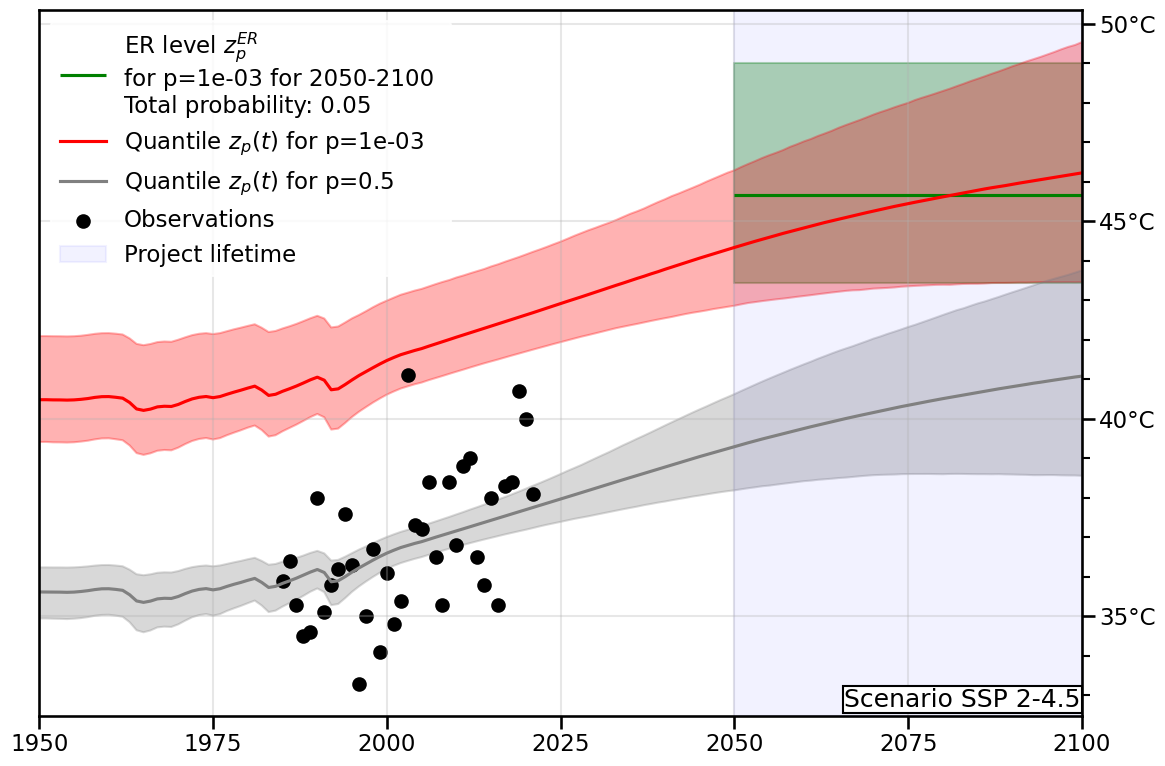

In [20]:
ofile=os.path.join(  pathOut+"AnnexeFigure2.pdf" )
pdf= mpdf.PdfPages( ofile )
fig = plt.figure( figsize = (12,8) )
sns.set_context("talk")

p=1/T

label = ["Project lifetime",
         "Quantile $z_p(t)$ for p="+"{:.0e}".format(p),
         "Quantile $z_p(t)$ for p=0.5",
         "Observations",
         "ER level $z_p^{ER}$ \nfor p="+"{:.0e}".format(p)+" for 2050-2100 \nTotal probability: "+str(round(1-Eq_Reliability_T,2))  ]



ax = fig.add_subplot( 1 , 1 ,  1 )

plt.hlines(y=Qm_EQR +bias_multi,
           xmin=T1, xmax=np.max(time_period),
           color='g', linestyle='-',
           label=label[4])


ax.fill_between( time_study , 
                 Ql_vect,
                Qu_vect,
                color = "green" ,
                alpha = 0.3 )





ax.plot( time_period ,
        Q_1000_posterior_quantiles.loc["BE",time_period] +bias_multi,
        color = "red" ,
        label=label[1])
ax.fill_between( time_period , 
                Q_1000_posterior_quantiles.loc["ql",time_period] +bias_multi,
                Q_1000_posterior_quantiles.loc["qu",time_period]+bias_multi ,
                color = "red" ,
                alpha = 0.3 )


ax.plot( time_period ,
        Q_2_posterior_quantiles.loc["BE",time_period] +bias_multi,
        color = "grey" ,
        label=label[2])
ax.fill_between( time_period ,
                Q_2_posterior_quantiles.loc["ql",time_period] +bias_multi,
                Q_2_posterior_quantiles.loc["qu",time_period]+bias_multi ,
                color = "grey" ,
                alpha = 0.3 )

ax.scatter( Yo.index, Yo+bias_multi,
           color = "black" ,
           label=label[3])





ax.axvspan(T1, T2,
           alpha=0.05,
           color='blue',
           label=label[0])

ax.text(2100-0.2, plt.ylim()[0]+0.1, 'Scenario SSP 2-4.5', color='black', ha="right", va="bottom",
        bbox=dict(facecolor='white', edgecolor='black',pad=1))


#label = ["Time period","RL 1000y", "RL 2y", "Obs", "EQR"]
legend = [mplpatch.Patch(facecolor = c , edgecolor = c , label = l , alpha = 0.5 ) for c,l in zip(["blue","red","grey","black","green"],label)]

fig.set_tight_layout(True)
ax.set(xlim=(1950,np.max(time_period)))
ax.xaxis.set_major_locator(MultipleLocator(25))


plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d°C'))
ax.yaxis.tick_right()
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.grid(alpha=0.3)

#ax.legend( frameon=False, )#handles = legend ,loc='upper left')
leg=ax.legend( )
leg.get_frame().set_edgecolor('white')

plt.show()
pdf.savefig(fig, bbox_inches = 'tight')
plt.close(fig)
pdf.close()

### Predictive effective return levels

In [21]:

def predictive_quantile_t(t,params,p,size=1000,m='Multi_Synthesis'):
    loc=params.loc[t,:,'F','loc' ,m].values.squeeze()
    scale=params.loc[t,:,'F','scale'  ,m].values.squeeze()
    shape=params.loc[t,:,'F','shape' ,m].values.squeeze()
    pred_dist_s=[]
    for j in range(size):
        pred_dist_s.extend(sc.genextreme.rvs( c=-shape,loc=loc,
                            scale=scale).flatten().tolist() )
    z_t_p=np.quantile(pred_dist_s,1-p)
    return(z_t_p)


In [22]:
z_pred=[predictive_quantile_t(t,params_CXCB,p,size=1000,m='Multi_Synthesis') for t in time_period]
z_pred

[4.039224348396604,
 4.026778796660151,
 4.0504498404505505,
 4.056492419044001,
 4.057888445675792,
 4.064418217881209,
 3.966831479358432,
 3.8369284012481595,
 3.821614516833044,
 3.8571035498313297,
 3.8962549323591738,
 3.9473928540656305,
 3.949660471847013,
 3.9589979026214914,
 3.9704680807287027,
 4.008532336616627,
 4.036768271040085,
 4.047065729428867,
 4.0632400668782145,
 4.076314497261735,
 4.086272629375944,
 4.1065414726922125,
 4.09641744145199,
 4.110649500047664,
 4.123317290340897,
 4.134299048039915,
 4.120189651938146,
 4.1118676039623105,
 4.118736391020024,
 4.134507366769765,
 4.140855218633179,
 4.141163647559013,
 4.16184630518433,
 4.0365825869064595,
 3.718773062067681,
 3.691191168083279,
 3.7258989087225878,
 3.7426962989910564,
 3.793157913886487,
 3.8188690854401295,
 3.8164644972414012,
 3.833831613109118,
 3.8663796625271902,
 3.9472316726448247,
 4.009563198028301,
 4.067766210097908,
 4.0637764112425865,
 4.068642885720717,
 4.091711317914904,
 4.1

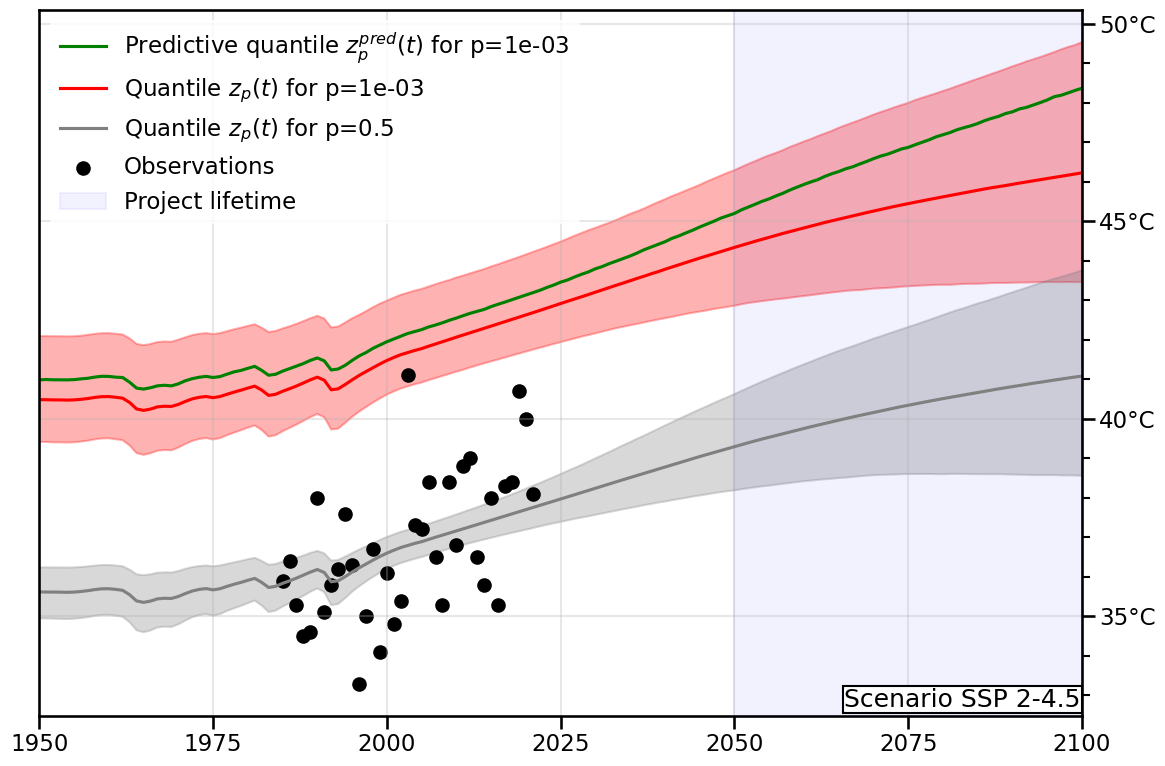

In [23]:
#Modify label 4 
ofile=os.path.join(  pathOut+"AnnexeFigure3.pdf" )
pdf= mpdf.PdfPages( ofile )
fig = plt.figure( figsize = (12,8) )
sns.set_context("talk")

p=1/T

label = ["Project lifetime",
         "Quantile $z_p(t)$ for p="+"{:.0e}".format(p),
         "Quantile $z_p(t)$ for p=0.5",
         "Observations",
         "Predictive quantile $z_p^{pred}(t)$ for p="+"{:.0e}".format(p) ]



ax = fig.add_subplot( 1 , 1 ,  1 )


ax.plot( time_period ,
        [i+bias_multi for i in z_pred],
        color = "green" ,
        label=label[4])



ax.plot( time_period ,
        Q_1000_posterior_quantiles.loc["BE",time_period] +bias_multi,
        color = "red" ,
        label=label[1])
ax.fill_between( time_period , 
                Q_1000_posterior_quantiles.loc["ql",time_period] +bias_multi,
                Q_1000_posterior_quantiles.loc["qu",time_period]+bias_multi ,
                color = "red" ,
                alpha = 0.3 )


ax.plot( time_period ,
        Q_2_posterior_quantiles.loc["BE",time_period] +bias_multi,
        color = "grey" ,
        label=label[2])
ax.fill_between( time_period ,
                Q_2_posterior_quantiles.loc["ql",time_period] +bias_multi,
                Q_2_posterior_quantiles.loc["qu",time_period]+bias_multi ,
                color = "grey" ,
                alpha = 0.3 )

ax.scatter( Yo.index, Yo+bias_multi,
           color = "black" ,
           label=label[3])





ax.axvspan(T1, T2,
           alpha=0.05,
           color='blue',
           label=label[0])

ax.text(2100-0.2, plt.ylim()[0]+0.1, 'Scenario SSP 2-4.5', color='black', ha="right", va="bottom",
        bbox=dict(facecolor='white', edgecolor='black',pad=1))


#label = ["Time period","RL 1000y", "RL 2y", "Obs", "EQR"]
legend = [mplpatch.Patch(facecolor = c , edgecolor = c , label = l , alpha = 0.5 ) for c,l in zip(["blue","red","grey","black","green"],label)]

fig.set_tight_layout(True)
ax.set(xlim=(1950,np.max(time_period)))
ax.xaxis.set_major_locator(MultipleLocator(25))


plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d°C'))
ax.yaxis.tick_right()
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.grid(alpha=0.3)

#ax.legend( frameon=False, )#handles = legend ,loc='upper left')
leg=ax.legend( )
leg.get_frame().set_edgecolor('white')

plt.show()
pdf.savefig(fig, bbox_inches = 'tight')
plt.close(fig)
pdf.close()